# Training the deep attractor network

This notebook contains a detailed example of how to train the deep attractor network model.  Filepaths to load training data must be filled in to run this notebook.

In [1]:
import sys
import time

import numpy as np

from magnolia.dnnseparate.DANmodel import DANModel
from magnolia.iterate.supervised_iterator import SupervisedMixer
from magnolia.iterate.hdf5_iterator import SplitsIterator


import IPython
from IPython.display import Audio
from matplotlib import pyplot as plt
fig_size = [0,0]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

### Training parameters
        batchsize  : Number of examples per batch in training
        max_snr    : Maximum SNR of mixes used in training
        datashape  : (Time, Frequency) shape of the examples within each batch

In [2]:
batchsize = 256
max_snr = 5
datashape = (40, 257)

### Setting up data I/O

For training, only the training dataset is needed. The other two datasets can be used for evaluation. The (training set, or in set) speaker keys have been separated according to speaker gender.

In [3]:
libritrain='/home/cstephenson/Data/librispeech/processed_train-clean-100.h5'

with open('/home/cstephenson/Magnolia/data/librispeech/authors/train-clean-100-F.txt','r') as speakers:
    keys = speakers.read().splitlines()
    speaker_keys = keys[:]
    in_set_F = keys[:]

with open('/home/cstephenson/Magnolia/data/librispeech/authors/train-clean-100-M.txt','r') as speakers:
    keys = speakers.read().splitlines()
    speaker_keys += keys
    in_set_M = keys[:]

# Make a training set mixer with holdout sets

SplitsIterator handles (deterministically) splitting the training set into three partitions. 80% of the training data is used to train the model, 10% is used to evaluate the training progress on unseen examples, and the last 10% is reserved to evaluate the performance of the model on unseen examples from speakers in the training set.

In [4]:
siterator = SplitsIterator([0.8,0.1,0.1], libritrain, speaker_keys=speaker_keys, shape=datashape, return_key=True)
siterator.set_split(0)

mixer = SupervisedMixer([siterator,siterator], shape=datashape, 
                        mix_method='add', diffseed=True)

### Helper functions to create batches of training data

These are functions which can be used with the mixers to create mixes that aren't 1:1

In [5]:
def get_id(filepath):
    '''
    Get the speaker ID from the audio filepath
    '''
    speaker_id = filepath.split('/')[0]
    return speaker_id

        
def create_mix(mixer, max_snr):  
    '''
    Create a mixed example from the mixer with a max SNR of max_snr
    '''
    data = next(mixer)
    
    # Get the IDs for the speakers in the mix
    f1 = data[1][0]
    f2 = data[2][0]
    
    id1 = mixer.label2dict(get_id(f1))
    id2 = mixer.label2dict(get_id(f2))
    
    # Get the magnitude spectrograms for each singal
    x1 = np.abs(data[1][1])
    x2 = np.abs(data[2][1])
    
    # Mix the signals at a random SNR between 0 and max_snr
    weight = np.random.rand()
    weight = (max_snr-2)/max_snr*weight + 2/max_snr
    
    a1 = weight/2
    a2 = 1-weight/2
    
    S = a1*x1 + a2*x2

    # Scale the combined magnitude spectrogram to make an input feature
    Sq = np.sqrt(S)
    Sq = (Sq - Sq.min())/(Sq.max() - Sq.min())
    
    # Stack the targets and IDs together 
    y = np.stack([a1*x1,a2*x2],axis=2)
    I = np.stack([id1,id2])
    
    return Sq, y, I, S

def create_batch(mixer, batch_size, max_snr):
    '''
    Create a batch of training data mixed between 0 and max_snr
    '''
    
    # Empty lists to contain the data
    X_list = []
    I_list = []
    y_list = []
    S_list = []
    
    # Create batch_size examples and store them
    for i in range(batch_size):
        x, y, i, s = create_mix(mixer,5)
        
        X_list.append(x)
        I_list.append(i)
        y_list.append(y)
        S_list.append(s)
        
    # Return the examples as np arrays
    return np.stack(X_list), np.stack(y_list), np.stack(I_list), np.stack(S_list)

### Create a batch of validation data
To generate a batch from the validation split of the training dataset, the splits iterator can have the split set to the validation split and the mixer can be used as before.

In [6]:
siterator.set_split(1)
Xinv, Ydv, Idv, Sdv = create_batch(mixer,batchsize,max_snr)
siterator.set_split(0)

# Initialize an instance of the DAN model

In [7]:
# Initialize the model
model = DANModel(nonlinearity='tanh', normalize=False)
model.initialize()

# Get the cost before training
Xdata, Ydata, Idata, Sdata = create_batch(mixer,batchsize, max_snr)

c = model.get_cost(Xdata,Ydata,Idata,Sdata)
c_v = model.get_cost(Xinv, Ydv, Idv, Sdv)

# Bookkeeping to track training progress
iterations = [0]
costs = [c]
t_costs = [c]
v_costs = [c_v]

times = []
last_saved = 0

# Training loop

Here the model is iteratively trained on batches generated by the mixer. The model is saved every time the validation cost reaches a new minimum value. The training can be configured to stop if the model has not been saved after a specified number of iterations have elapsed since the previous save. Plots of the training cost and the validation set are created as well.

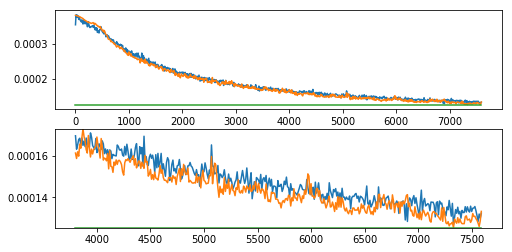

Cost on iteration 7590 is 0.000133241
Last saved 7590 iterations ago.
Time per batch: 0.2211406


In [ ]:
# Number of iterations to train for (should be large)
num_iterations = 1000000
# Threshold for stopping if the model hasn't improved for this many consecutive iterations
stop_threshold = 10000
# Allow model saving?
save = False

# Find the number of iterations already elapsed (Useful for resuming training)
try:
    start = iterations[-1]
except:
    start = 0
    
# Ensure that the iterator is set to iterate over the training split    
siterator.set_split(0)

# Iterate over training batches
for i in range(num_iterations):
    
    # Generate a batch of training data
    Xdata, Ydata, Idata, Sdata = create_batch(mixer,batchsize,max_snr)
    
    # Train on the batch and time the process
    tick = time.clock()
    c = model.train_on_batch(Xdata,Ydata,Idata,Sdata)
    tock = time.clock()
    times.append(tock-tick)
        
    # Store the cost on this batch
    costs.append(c)
    
    # Every 10 batches, evaluate the model on the validation and plot the cost curves
    if (i+1) % 10 == 0:
        IPython.display.clear_output(wait=True)
        
        # Get the cost on the validation batch
        c_v = model.get_cost(Xinv, Ydv, Idv, Sdv)
    
        # Check if the validation cost is below the minimum validation cost, and if so, save it.
        if c_v < min(v_costs) and len(iterations) > 0 and save == True:
            print("Saving the model because c_v is", min(v_costs) - c_v, "below the old min.")
            
            # Save the model to the specified path
            model.save('models/magnolia/DAN41.ckpt')
            
            # Record the iteration of the most recent save
            last_saved = iterations[-1]
        
        # Store the training and validation cost
        t_costs.append(np.mean(costs))
        v_costs.append(c_v)
        
        # Store the current iteration number
        iterations.append(i + 1 + start)
        
        # Compute the scale quantities for plotting
        length = len(iterations)
        cutoff = int(0.5*length)
        lowline = [min(v_costs)]*len(iterations)
        
        # Generate the plots and show them
        f, (ax1, ax2) = plt.subplots(2,1)
        
        ax1.plot(iterations,t_costs)
        ax1.plot(iterations,v_costs)
        ax1.plot(iterations,lowline)
        
        y_u = max(max(t_costs[cutoff:]),max(v_costs[cutoff:]))
        y_l = min(min(t_costs[cutoff:]),min(v_costs[cutoff:]))
        
        ax2.set_ylim(y_l,y_u)
        
        ax2.plot(iterations[cutoff:], t_costs[cutoff:])
        ax2.plot(iterations[cutoff:], v_costs[cutoff:])
        ax2.plot(iterations[cutoff:], lowline[cutoff:])
        plt.show()
        
        print("Cost on iteration", iterations[-1], "is", c_v)
        print("Last saved",iterations[-1]-last_saved,"iterations ago.")
        print("Time per batch:", np.mean(times[-10:]) )
        
        # Reset the costs over the last 10 iterations
        costs = []
        
        # Stop training if the number of iterations since the last save exceeds the threshold
        if iterations[-1]-last_saved > stop_threshold:
            print("Done!")
            break